# Linear regression

In this lesson we will learn how to perform a simple linear regression by examining the counts, weight, and size measurements of juvenile snowshoe hares (*Lepus americanus*) observed at the Bonanza Creek Experimental Forest from 1999 to 2012 @kielland_snowshoe_2017. 

## About the data

Size measurements, sex, and age of snowshoe hares were collected and made available by Dr. Knut Kielland and colleagues at the [Bonanza Creek Experimental Forest Long Term Ecological Research (LTER) site](https://www.lter.uaf.edu) located approximately 20 km southwest of Fairbanks, Alaska, USA. The data contains observations of 3380 snowshoe hares obtained by capture-recapture studies conducted yearly from 1999 to 2012 in three sampling sites: Bonanza Riparian, Bonanza Mature and Bonanza Black Spruce. 

## Data exploration

Let's start by loading the data and taking a very high-level look at it:


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [9]:
hares= pd.read_csv(os.path.join('data','knb-lter-bnz','55_Hare_Data_2012.txt'))
hares.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
0,11/26/1998,NaN,bonrip,1A,414D096A08,NaN,NaN,NaN,1370.0,160.0,NaN,917.0,51,Population
1,11/26/1998,NaN,bonrip,2C,414D320671,NaN,M,NaN,1430.0,NaN,NaN,936.0,51,Population
2,11/26/1998,NaN,bonrip,2D,414D103E3A,NaN,M,NaN,1430.0,NaN,NaN,921.0,51,Population
3,11/26/1998,NaN,bonrip,2E,414D262D43,NaN,NaN,NaN,1490.0,135.0,NaN,931.0,51,Population
4,11/26/1998,NaN,bonrip,3B,414D2B4B58,NaN,NaN,NaN,1710.0,150.0,NaN,933.0,51,Population


## Examining hares age data

In this example we are interested in working with data from juvenile hares exclusively. So we will:

1. Examine the values in the `age` column
2. Filter for observations in which age is 'adult' or 'juvenile'
3. Investigate the age distributions across time

From the [dataset's metadata](https://portal.edirepository.org/nis/metadataviewer?packageid=knb-lter-bnz.55.22) we know there are three allowedd values in the `age` column: 

- 'a' for 'adult', 
- 'j' for 'juvenile', and 
- 'm' for 'mortality'. 

In [10]:
# Examine unique values and counts in age column
pd.DataFrame(hares['age'].value_counts(dropna=False))

,count
age,
NaN,2111
A,564
J,267
a,183
j,128
1/2/2013,21
1/4/2013,21
3/4/2013,18
1,12


In [12]:
# Update age values to juvenile and adult for observations where 'a' and 'j' are included
hares.loc[hares.age.str.contains('j', case=False, na=False), 'age'] = 'juvenile'
hares.loc[hares.age.str.contains('a', case=False, na=False), 'age'] = 'adult'

# Filter for confirmed observations of juvenile and adult hares
hares_juv_adult = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(f"Number of selected juvenile and adult hares: {len(hares_juv_adult)}")

Number of selected juvenile and adult hares: 1155


In [ ]:
# Update date column to date-time
hares['date'] = pd.to_datetime(hares['date'])
print(hares.date.dtype)

datetime64[ns]


In [15]:
# Filter for confirmed observations of juvenile and adult hares
hares_juv_adult = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(f"Number of selected juvenile and adult hares: {len(hares_juv_adult)}")

Number of selected juvenile and adult hares: 1155


In [ ]:
# select year and make it a new column 
hares_juv_adult['year'] = hares_juv_adult.date.dt.year 

In [21]:
hares_per_year = (hares_juv_adult.groupby(['year', 'age']).size()
 .reset_index(name='counts')
 .pivot(index='year', columns='age', values='counts'))
hares_per_year

age,adult,juvenile
year,,
1999,150.0,126.0
2000,159.0,67.0
2001,72.0,22.0
2002,3.0,NaN
2003,1.0,18.0
2004,NaN,8.0
2005,95.0,48.0
2006,101.0,15.0
2007,13.0,5.0


<Axes: xlabel='year'>

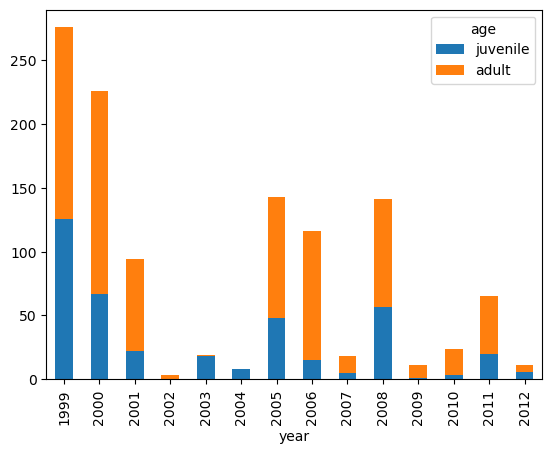

In [22]:
hares_per_year[['juvenile', 'adult']].plot(kind = 'bar', stacked=True)

## Selected Junveille hares and width / binf foot measurements  

Number of juvenile hares with hind foot and weight measurements: 265


<Axes: xlabel='hindft', ylabel='weight'>

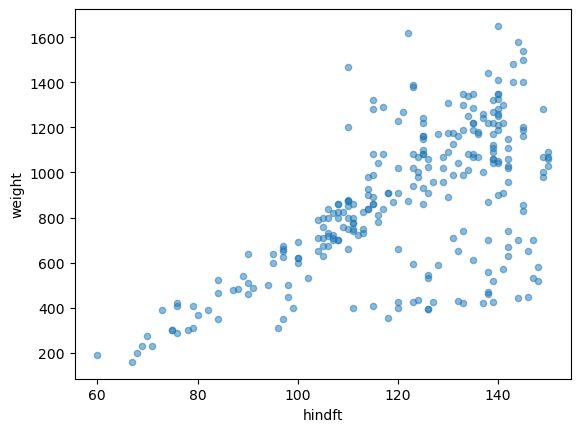

In [26]:
# Subset juvenile hares with hind foot and weight measurements
juveniles_weight_hindft = hares_juv_adult[(hares_juv_adult['hindft'].notna()) & 
                                          (hares_juv_adult['weight'].notna()) &
                                          (hares_juv_adult['age']=='juvenile')]


print(f"Number of juvenile hares with hind foot and weight measurements: {len(juveniles_weight_hindft)}")
juveniles_weight_hindft.plot.scatter(x='hindft', y='weight', alpha=0.5)

## Linear regression

For our analysis we want to investigate possible relations between hind foot length and weight for juvenile hares.

Let's investigate whether a linear model is an adequate way to describe this data. To do this we will use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model from the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library. 


The trickiest part of fiting the model is to get the data in the required shape:

- input data (the x-values, independent variable, or training data) shape should be `(n_samples, 1)`. The 1 comes from having a single feature modeling the output data.
- output data (the y-values, dependent variable, or target data) shape should be `(n_samples,)`.

In [ ]:
X = np.array(juveniles_weight_hindft['hindft']).
X

array([126., 137., 144., 115., 132., 139., 124., 126., 120., 139.,  87.,
       126., 118., 128., 127., 123., 120., 126., 120., 123., 145., 125.,
       136., 139., 126., 123., 130., 123., 125., 140., 132., 115., 127.,
       129., 120., 142., 141., 140., 115., 140., 139., 149., 133., 131.,
       122., 135., 123., 135., 137., 150., 142., 139., 117., 142., 117.,
       149., 134., 126., 132., 149., 124., 110., 150., 118., 140., 140.,
       150., 130., 149., 123., 120., 136., 140., 140., 144., 138., 123.,
       144., 140., 142., 145., 138., 145., 138., 145., 139., 147., 142.,
       142., 141., 139., 148., 148., 139., 147., 145., 145., 138., 142.,
       146., 146., 135., 139., 137., 115., 137., 145., 141., 143., 111.,
       133., 133., 110., 141., 132., 142., 138., 131., 145., 108., 134.,
       133., 110., 104., 111., 108., 131., 130., 118.,  70., 111., 111.,
       131.,  98., 140.,  99., 113.,  94.,  98., 100., 100.,  96.,  95.,
       100.,  95.,  97.,  84.,  90., 108., 106., 11

In [29]:
# x-values
X = np.array(juveniles_weight_hindft['hindft']).reshape((-1, 1))   # Reshape to (n_samples, 1)
print(f"Input data shape: {X.shape}")

# y-values
y = np.array(juveniles_weight_hindft['weight'])    # Shape is (n_samples,)
print(f"Output data shape: {y.shape}")

Input data shape: (265, 1)
Output data shape: (265,)


Next, we create a LinearRegression instance and fit it to our data to create a model. From the model we extract the coefficient of determination or 
, and the x-axis intercept and slope from our linear model.

In [34]:
# Fit model
model = LinearRegression().fit(X, y)

In [35]:
# Calculate R^2
R_sq = model.score(X, y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")


Coefficient of determination (R^2): 0.3871164783665735
x-axis intercept: -352.77198564640685
Slope: 10.092239638623013


Remember that the equation of the linear model is given by

$$\hat{y} = \beta_0 + \beta_1 x, $$

where

- $x$ = input variable
- $\hat{y}$ = **estimated $y$ value** at $x$ from the linear model 
- $\beta_0$ = the **$x$-intercept** of the linear model, this is interpreted as the estimated average value when $x=0$
- $\beta_1$ = the **slope** of the linear model, this is the estimated difference in the predicted value $\hat{y}$ per unit of $x$.

The **coefficient of determination**, $R^2$ is between 0 and 1. It is interpreted as the amount of variation in the outcome variable $y$ that is explained by the least squares line the variable $x$. 

-->

We can use all this information to plot our linear model together with our data:

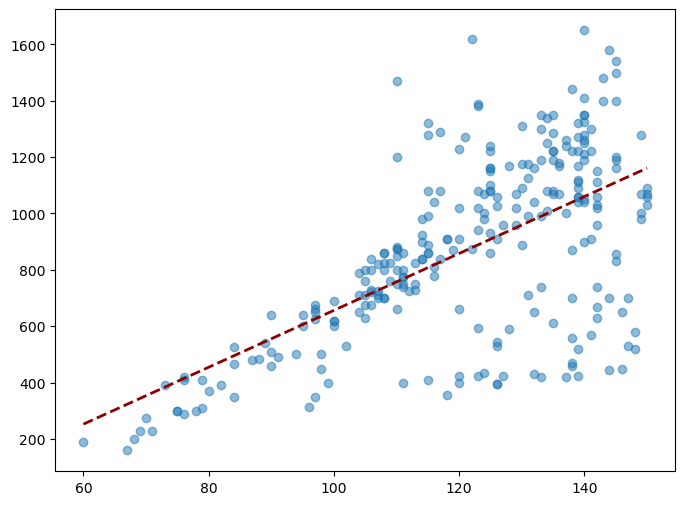

In [39]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x = juveniles_weight_hindft['hindft'], 
           y = juveniles_weight_hindft['weight'], 
           alpha = 0.5)

# Dfine paraamters of regression line 
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# plot the line 
ax.plot([x_start, x_end], 
        [slope*x_start + intercept, slope*x_end + intercept],
        color="darkred", 
        lw=2, 
        linestyle="--")


:::{.callout-tip}
# Exercise
Answer the following questions:

a. Does it make sense to interpret the $x$-axis intercept as an estimated measurement of weight?

b. What is the estimated change in weight for each millimiter increase in hind foot length?

c. Does a linear model of weight with respect to hind foot length account completely for the change in the dependent variable? What other variables could be worth exploring to model the weight?

d. How would you use the linear model to estimate the weight of a juvenile hare with hind foot length of 90 mm?
:::

<!--
:::{.callout-tip}
# Exercise 2

This would be an exercise about doing linear regression while grouping by sex
:::
-->